# Vi-T for CIFAR-10

## Import Libraries

In [ ]:
%pip install transformers pygwalker wandb
%pip install "git+https://github.com/b-re-w/lattent.git#egg=lattent[pytorch]"

In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from transformers import ViTConfig, ViTModel, PretrainedConfig

from lattent import TTTForCausalLM, TTTCausalLMOutput

from torchvision import transforms, datasets, utils

from os import path, rename, mkdir, listdir

from tqdm.notebook import tqdm
import pygwalker as pyg
import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# WandB Initialization
wandb.init(project="cifar10_pytorch")
#wandb.init(project="cifar10_pytorch_ttt")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: brew (brew-research). Use `wandb login --relogin` to force relogin


### Check GPU Availability

In [4]:
!nvidia-smi

Sun Dec  1 19:33:12 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |  15554MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [5]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 5

if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_NUM)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1
print(f"INFO: Using device - {device}:{DEVICE_NUM}")

INFO: Using device - cuda:5


## Load DataSets

In [6]:
# Image Resizing and Tensor Conversion
IMG_SIZE = (32, 32)
IMG_NORM = dict(  # CIFAR10 Normalization
    mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
)

augmenter = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize Image
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

resizer = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize Image
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

In [7]:
from sklearn.model_selection import train_test_split

DATA_ROOT = path.join(".", "data")

train_dataset = datasets.CIFAR10(root=DATA_ROOT, download=True, train=True, transform=augmenter)
test_dataset = datasets.CIFAR10(root=DATA_ROOT, download=True, train=False, transform=resizer)

test_labels = np.array([test_dataset[i][1] for i in range(len(test_dataset))])
valid_indices, test_indices = train_test_split(np.arange(len(test_dataset)), test_size=0.9, stratify=test_labels, random_state=42)
valid_dataset = Subset(test_dataset, valid_indices)
test_dataset = Subset(test_dataset, test_indices)

CLASSES = train_dataset.classes
print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

Files already downloaded and verified
Files already downloaded and verified
INFO: Dataset loaded successfully. Number of samples - Train(50000), Valid(1000), Test(9000)


In [8]:
# Train Dataset Distribution
pyg.walk(pd.DataFrame(dict(lable=[CLASSES[lb] for lb in train_dataset.targets])))

Box(children=(HTML(value='\n<div id="ifr-pyg-0006283a81154ee72yZADpBrbW9snjoH" style="height: auto">\n    <hea…

In [9]:
# Valid Dataset Distribution
pyg.walk(pd.DataFrame(dict(lable=[CLASSES[lb] for dt, lb in valid_dataset])))

Box(children=(HTML(value='\n<div id="ifr-pyg-0006283a8120a6c5sbL01z2XecuOJlqh" style="height: auto">\n    <hea…

In [10]:
# Test Dataset Distribution
pyg.walk(pd.DataFrame(dict(lable=[CLASSES[lb] for dt, lb in test_dataset])))

Box(children=(HTML(value='\n<div id="ifr-pyg-0006283a814bf2e3r1bXyVvwWpAxoial" style="height: auto">\n    <hea…

## DataLoader

In [11]:
# Set Batch Size
BATCH_SIZE = 512, 200, 200

In [12]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE[0], shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE[1], shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE[2], shuffle=False, num_workers=cpu_cores)

INFO: Number of CPU cores - 48


In [13]:
# Image Visualizer
def imshow(image_list, mean=IMG_NORM['mean'], std=IMG_NORM['std']):
    np_image = np.array(image_list).transpose((1, 2, 0))
    de_norm_image = np_image * std + mean
    plt.figure(figsize=(10, 10))
    plt.imshow(de_norm_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


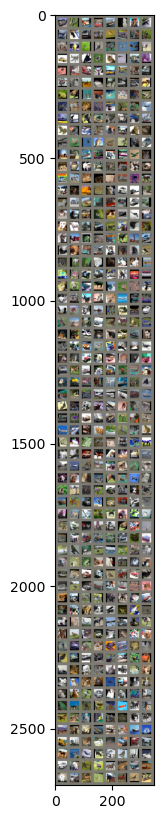

In [14]:
images, targets = next(iter(train_loader))
grid_images = utils.make_grid(images, nrow=8, padding=10)
imshow(grid_images)

## Define Model

In [15]:
common_config = dict(
    image_size=IMG_SIZE[0],
    num_channels=3,
    patch_size=8,
    hidden_size=768,
    num_hidden_layers=6,
    num_attention_heads=8,
    intermediate_size=768,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
    qkv_bias=True,
    encoder_stride=16
)

### Normal Vi-T

In [16]:
class ViTImageClassifier(nn.Module):
    def __init__(self, config: ViTConfig, num_classes: int):
        super().__init__()
        self.config = config
        self.vit = ViTModel(config=config)
        self.fc = nn.Linear(self.config.hidden_size, num_classes)

    def forward(self, x):
        out = self.vit(x)
        pooled = out.pooler_output  # [batch_size, hidden_size]
        logits = self.fc(pooled)  # [batch_size, num_classes]
        return logits

In [17]:
# Initialize Model
model = ViTImageClassifier(config=ViTConfig(**common_config), num_classes=len(train_dataset.classes))
#model.to(device)
model

ViTImageClassifier(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-5): 6 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, o

### TTT Vi-T

In [18]:
class TTTVisionConfig(PretrainedConfig):
    """Vision TTT configuration."""

    model_type = "vision_ttt"

    def __init__(
            self,
            image_size=224,
            patch_size=16,
            num_channels=3,
            num_classes=1000,
            hidden_size=768,
            intermediate_size=3072,
            num_hidden_layers=12,
            num_attention_heads=12,
            hidden_act="gelu",
            initializer_range=0.02,
            rms_norm_eps=1e-6,
            pretraining_tp=1,
            use_cache=True,
            mini_batch_size=16,
            use_gate=False,
            share_qk=False,
            ttt_layer_type="linear",
            ttt_base_lr=1.0,
            pre_conv=True,
            conv_kernel=4,
            scan_checkpoint_group_size=0,
            **kwargs
    ):
        super().__init__(**kwargs)
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_channels = num_channels

        self.num_classes = num_classes
        self.vocab_size = num_classes

        self.hidden_size = hidden_size
        self.intermediate_size = intermediate_size
        self.num_hidden_layers = num_hidden_layers
        self.num_attention_heads = num_attention_heads

        self.hidden_act = hidden_act
        self.initializer_range = initializer_range
        self.rms_norm_eps = rms_norm_eps
        self.pretraining_tp = pretraining_tp
        self.use_cache = use_cache

        self.use_gate = use_gate
        self.share_qk = share_qk
        self.ttt_layer_type = ttt_layer_type
        self.ttt_base_lr = ttt_base_lr
        self.mini_batch_size = mini_batch_size

        self.pre_conv = pre_conv
        self.conv_kernel = conv_kernel
        self.scan_checkpoint_group_size = scan_checkpoint_group_size

        # Vision-specific attributes
        self.num_patches = (image_size // patch_size) ** 2

In [19]:
from einops.layers.torch import Rearrange


class PatchEmbedding(nn.Module):
    """Converts images into patches and projects them into the model dimension."""
    def __init__(self, config: TTTVisionConfig):
        super().__init__()
        self.config = config
        self.image_size = config.image_size
        self.patch_size = config.patch_size
        self.num_patches = config.num_patches
        self.num_channels = config.num_channels

        # Patch splitting and flattening
        patch_dim = self.num_channels * self.patch_size * self.patch_size

        self.to_patch_embedding = nn.Sequential(
            # Split image into patches and flatten
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size),
            nn.LayerNorm(patch_dim),
            # Project to hidden dimension
            nn.Linear(patch_dim, config.hidden_size),
            nn.LayerNorm(config.hidden_size),
        )

        # Learnable position embeddings for patches
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, config.hidden_size))

        # [CLS] token embedding
        self.cls_token = nn.Parameter(torch.randn(1, 1, config.hidden_size))

        # Dropout
        self.dropout = nn.Dropout(0.1)

    def forward(self, pixel_values: torch.FloatTensor) -> torch.FloatTensor:
        B = pixel_values.shape[0]

        # Convert image to patches -> (batch_size, num_patches, hidden_size)
        x = self.to_patch_embedding(pixel_values)

        # Add position embeddings
        x = x + self.pos_embedding

        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        return self.dropout(x)

In [20]:
from transformers.utils import ModelOutput
from typing import *


class TTTForVisionCausalLM(TTTForCausalLM):
    config_class = TTTVisionConfig

    def __init__(self, config: TTTVisionConfig):
        super().__init__(config)
        self.patch_embed = PatchEmbedding(config)

        # Initialize weights
        self.post_init()

    def forward(
            self,
            input_ids: Optional[torch.LongTensor] = None,  # [batch_size, seq_len]
            attention_mask: Optional[torch.Tensor] = None,  # [batch_size, seq_len]
            position_ids: Optional[torch.LongTensor] = None,
            inputs_embeds: Optional[torch.FloatTensor] = None,  # [batch_size, seq_len, hidden_size]
            pixel_values: Optional[torch.FloatTensor] = None,  # [batch_size, channels, height, width]
            cache_params: Optional[Any] = None,
            labels: Optional[torch.LongTensor] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
            use_cache: Optional[bool] = None,
            **kwargs
    ) -> Union[Tuple, TTTCausalLMOutput]:
        batch_size = None
        if pixel_values is not None:
            batch_size = pixel_values.shape[0]
        elif input_ids is not None:
            batch_size = input_ids.shape[0]
        elif inputs_embeds is not None:
            batch_size = inputs_embeds.shape[0]

        if batch_size is None:
            raise ValueError("No valid input provided to determine batch size")

        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        final_attention_mask = None
        final_embeds = None

        # 이미지 처리
        if pixel_values is not None:
            # [batch_size, num_patches + 1, hidden_size]
            image_embeds = self.patch_embed(pixel_values)
            image_attention_mask = torch.ones(
                (batch_size, image_embeds.shape[1]),
                dtype=torch.long,
                device=image_embeds.device
            )
            final_embeds = image_embeds  # [batch_size, num_patches + 1, hidden_size]
            final_attention_mask = image_attention_mask  # [batch_size, num_patches + 1]

        # 텍스트 처리 (선택적)
        if input_ids is not None or inputs_embeds is not None:
            if inputs_embeds is None:
                # [batch_size, seq_len] -> [batch_size, seq_len, hidden_size]
                inputs_embeds = self.get_input_embeddings()(input_ids)

            text_attention_mask = attention_mask if attention_mask is not None else torch.ones(
                (batch_size, inputs_embeds.shape[1]),
                dtype=torch.long,
                device=inputs_embeds.device
            )

            # 이미지가 있는 경우 텍스트와 연결
            if final_embeds is not None:
                # [batch_size, num_patches + 1 + seq_len, hidden_size]
                final_embeds = torch.cat([final_embeds, inputs_embeds], dim=1)
                # [batch_size, num_patches + 1 + seq_len]
                final_attention_mask = torch.cat([final_attention_mask, text_attention_mask], dim=1)
            else:
                final_embeds = inputs_embeds  # [batch_size, seq_len, hidden_size]
                final_attention_mask = text_attention_mask  # [batch_size, seq_len]

        if final_embeds is None:
            raise ValueError("Either pixel_values or input_ids/inputs_embeds must be provided")

        # TTT 모델 실행
        outputs = self.model(
            input_ids=None,
            attention_mask=final_attention_mask,
            position_ids=position_ids,
            inputs_embeds=final_embeds,
            cache_params=cache_params,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            use_cache=use_cache,
        )

        # [batch_size, total_seq_len, hidden_size]
        hidden_states = outputs[0]

        # 로짓 계산
        if self.config.pretraining_tp > 1:
            lm_head_slices = self.lm_head.weight.split(self.vocab_size // self.config.pretraining_tp, dim=0)
            logits = [F.linear(hidden_states, lm_head_slices[i]) for i in range(self.config.pretraining_tp)]
            logits = torch.cat(logits, dim=-1)  # [batch_size, total_seq_len, vocab_size]
        else:
            # [batch_size, total_seq_len, vocab_size]
            logits = self.lm_head(hidden_states)
        logits = logits.float()

        # Loss 계산
        loss = None
        if labels is not None and (input_ids is not None or inputs_embeds is not None):
            text_start = self.config.num_patches + 1 if pixel_values is not None else 0
            # [batch_size, seq_len - 1, vocab_size]
            shift_logits = logits[:, text_start:-1, :].contiguous()
            # [batch_size, seq_len - 1]
            shift_labels = labels[:, 1:].contiguous()

            loss_fct = nn.CrossEntropyLoss()
            shift_logits = shift_logits.view(-1, self.config.vocab_size)  # [batch_size * (seq_len - 1), vocab_size]
            shift_labels = shift_labels.view(-1)  # [batch_size * (seq_len - 1)]
            shift_labels = shift_labels.to(shift_logits.device)
            loss = loss_fct(shift_logits, shift_labels)

        if not return_dict:
            output = (logits,) + outputs[1:]
            return (loss,) + output if loss is not None else output

        return TTTCausalLMOutput(
            loss=loss,
            logits=logits,  # [batch_size, total_seq_len, vocab_size]
            cache_params=outputs.cache_params,
            hidden_states=outputs.hidden_states
        )

    def prepare_inputs_for_generation(
            self,
            input_ids: Optional[torch.LongTensor] = None,
            attention_mask: Optional[torch.Tensor] = None,
            cache_params: Optional[Any] = None,
            inputs_embeds: Optional[torch.FloatTensor] = None,
            pixel_values: Optional[torch.FloatTensor] = None,
            **kwargs
    ):
        model_inputs = {}

        # 캐시가 있는 경우 마지막 토큰만 처리
        if cache_params is not None:
            if input_ids is not None:
                input_ids = input_ids[:, -1].unsqueeze(-1)
            if attention_mask is not None:
                attention_mask = attention_mask[:, -1].unsqueeze(-1)
            if inputs_embeds is not None:
                inputs_embeds = inputs_embeds[:, -1:, :]

        # 입력 설정
        if inputs_embeds is not None and cache_params is None:
            model_inputs["inputs_embeds"] = inputs_embeds
        elif input_ids is not None:
            model_inputs["input_ids"] = input_ids

        # 첫 forward pass에서만 이미지 처리
        if pixel_values is not None and cache_params is None:
            model_inputs["pixel_values"] = pixel_values

        model_inputs.update(
            {
                "cache_params": cache_params,
                "use_cache": kwargs.get("use_cache"),
                "attention_mask": attention_mask,
            }
        )

        return model_inputs

    def _update_model_kwargs_for_generation(
            self,
            outputs: ModelOutput,
            model_kwargs: Dict[str, Any],
            **kwargs
    ) -> Dict[str, Any]:
        model_kwargs["cache_params"] = outputs.get("cache_params", None)

        if "attention_mask" in model_kwargs:
            attention_mask = model_kwargs["attention_mask"]
            if attention_mask is not None:
                model_kwargs["attention_mask"] = torch.cat(
                    [attention_mask, attention_mask.new_ones((attention_mask.shape[0], 1))],
                    dim=-1,
                )

        # 첫 번째 forward pass 이후에는 이미지 처리 불필요
        if "pixel_values" in model_kwargs:
            del model_kwargs["pixel_values"]

        return model_kwargs

In [21]:
# Initialize Model
model = TTTForVisionCausalLM(config=TTTVisionConfig(
    **common_config, num_classes=len(train_dataset.classes), mini_batch_size=17
))
model.to(device)

TTTForVisionCausalLM(
  (model): TTTModel(
    (embed_tokens): Embedding(10, 768)
    (layers): ModuleList(
      (0-5): 6 x Block(
        (seq_modeling_block): TTTLinear(
          (q_proj): Linear(in_features=768, out_features=768, bias=False)
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=False)
          (o_proj): Linear(in_features=768, out_features=768, bias=False)
          (post_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        )
        (mlp): SwiGluMLP(
          (gate_proj): Linear(in_features=768, out_features=768, bias=False)
          (up_proj): Linear(in_features=768, out_features=768, bias=False)
          (down_proj): Linear(in_features=768, out_features=768, bias=False)
          (act_fn): GELUActivation()
        )
        (conv): Conv(
          (norm): RMSNorm()
          (conv): Conv1d(768, 768, kernel_size=(4,), stride=(1,), padding=(3,), groups=768)


## Training Loop

In [22]:
from IPython.display import display
import ipywidgets as widgets

# Interactive Loss Plot Update
def create_plot():
    train_losses, valid_losses = [], []

    # Enable Interactive Mode
    plt.ion()

    # Loss Plot Setting
    fig, ax = plt.subplots(figsize=(6, 2))
    train_line, = ax.plot(train_losses, label="Train Loss", color="purple")
    valid_line, = ax.plot(valid_losses, label="Valid Loss", color="red")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Cross Entropy Loss")

    # Display Plot
    plot = widgets.Output()
    display(plot)

    def update_plot(train_loss=None, valid_loss=None):
        if train_loss is not None:
            train_losses.append(train_loss)
        if valid_loss is not None:
            valid_losses.append(valid_loss)
        train_line.set_ydata(train_losses)
        train_line.set_xdata(range(len(train_losses)))
        valid_line.set_ydata(valid_losses)
        valid_line.set_xdata(range(len(valid_losses)))
        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [23]:
def avg(lst):
    try:
        return sum(lst) / len(lst)
    except ZeroDivisionError:
        return 0

In [24]:
# Set Epoch Count & Learning Rate
EPOCHS = 50
LEARNING_RATE = 3e-4, 1e-6
WEIGHT_DECAY = 0.05
MAX_GRAD_NORM = 1.0
USE_CACHE = False

criterion = nn.CrossEntropyLoss()
wandb.watch(model, criterion, log="all", log_freq=10)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE[0], weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=LEARNING_RATE[1])

### Normal Vi-T

Running Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Output()

Epoch [ 5/50], Step [98/98], Acc: 40.544009%, Loss: 1.631766, Valid Acc: 45.499998%, Valid Loss: 1.453616
Epoch [10/50], Step [98/98], Acc: 47.493985%, Loss: 1.446963, Valid Acc: 52.500004%, Valid Loss: 1.249227
Epoch [15/50], Step [98/98], Acc: 51.291990%, Loss: 1.348095, Valid Acc: 59.299999%, Valid Loss: 1.112553
Epoch [20/50], Step [98/98], Acc: 54.540008%, Loss: 1.266679, Valid Acc: 61.300004%, Valid Loss: 1.055249
Epoch [25/50], Step [98/98], Acc: 57.040006%, Loss: 1.196285, Valid Acc: 65.000004%, Valid Loss: 1.025907
Epoch [30/50], Step [98/98], Acc: 59.566015%, Loss: 1.134861, Valid Acc: 65.200001%, Valid Loss: 0.976828
Epoch [35/50], Step [98/98], Acc: 61.691999%, Loss: 1.071203, Valid Acc: 66.299999%, Valid Loss: 0.967953
Epoch [40/50], Step [98/98], Acc: 64.180005%, Loss: 1.005143, Valid Acc: 67.400002%, Valid Loss: 0.948045
Epoch [45/50], Step [98/98], Acc: 66.176009%, Loss: 0.956711, Valid Acc: 68.900001%, Valid Loss: 0.919700
Epoch [50/50], Step [98/98], Acc: 67.689997%, 

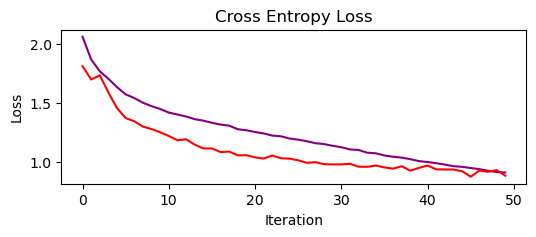

In [21]:
train_length, valid_length = map(len, (train_loader, valid_loader))

epochs = tqdm(range(EPOCHS), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        train_acc, train_loss = 0, 0

        # Training
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() / train_length
            corrects = (torch.max(outputs, 1)[1] == targets.data).sum()
            train_acc += corrects / len(train_dataset)

            train_progress.update(1)
            if i != train_length-1: wandb.log({'Acc': corrects/len(inputs)*100, 'Loss': loss.item()})
            print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{i+1:2}/{train_length}], Acc: {corrects/len(inputs):.6%}, Loss: {loss.item():.6f}", end="")

        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], Acc: {train_acc:.6%}, Loss: {train_loss:.6f}", end="")
        val_acc, val_loss = 0, 0

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum() / (len(inputs) * valid_length)
                valid_progress.update(1)

        update(train_loss=train_loss, valid_loss=val_loss)
        wandb.log({'Train Acc': train_acc*100, 'Train Loss': train_loss, 'Val Acc': val_acc*100, 'Val Loss': val_loss})
        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], Acc: {train_acc:.6%}, Loss: {train_loss:.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == EPOCHS else "")

In [22]:
if not path.isdir(path.join(".", "models")):
    import os
    os.mkdir(path.join(".", "models"))

# Model Save
save_path = path.join(".", "models", f"normal_vit_model.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ./models/normal_vit_model.pt


### TTT Vi-T

Running Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]

Output()

Epoch [ 5/50], Step [98/98], Acc: 54.118740%, Loss: 1.278221, Valid Acc: 59.400000%, Valid Loss: 1.158826
Epoch [10/50], Step [98/98], Acc: 63.901163%, Loss: 1.019646, Valid Acc: 67.800000%, Valid Loss: 0.937665
Epoch [15/50], Step [98/98], Acc: 69.243501%, Loss: 0.872512, Valid Acc: 70.900000%, Valid Loss: 0.815563
Epoch [20/50], Step [98/98], Acc: 72.956716%, Loss: 0.771882, Valid Acc: 71.100000%, Valid Loss: 0.826006
Epoch [25/50], Step [98/98], Acc: 76.027526%, Loss: 0.686565, Valid Acc: 74.200000%, Valid Loss: 0.768439
Epoch [30/50], Step [98/98], Acc: 78.125759%, Loss: 0.621822, Valid Acc: 74.700000%, Valid Loss: 0.727055
Epoch [35/50], Step [98/98], Acc: 80.762858%, Loss: 0.555285, Valid Acc: 76.200000%, Valid Loss: 0.754992
Epoch [40/50], Step [98/98], Acc: 82.131184%, Loss: 0.518507, Valid Acc: 75.000000%, Valid Loss: 0.794116
Epoch [45/50], Step [98/98], Acc: 83.221157%, Loss: 0.479955, Valid Acc: 75.800000%, Valid Loss: 0.759992
Epoch [50/50], Step [98/98], Acc: 84.546017%, 

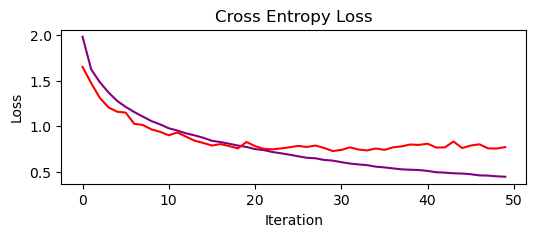

In [25]:
train_length, valid_length = map(len, (train_loader, valid_loader))

epochs = tqdm(range(EPOCHS), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
    tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        train_acc, train_loss, val_acc, val_loss = [], [], [], []

        # Training
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(pixel_values=inputs, labels=targets, use_cache=False).logits[:, -1, :]

            loss = criterion(outputs, targets)
            loss.backward()
            if MAX_GRAD_NORM > 0:
                nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
            optimizer.step()
            scheduler.step()

            train_loss.append(loss.item())
            train_acc.append((torch.max(outputs, 1)[1] == targets.data).sum().item() / len(inputs))

            train_progress.update(1)
            if i != train_length-1: wandb.log({'Acc': avg(train_acc)*100, 'Loss': avg(train_loss)})
            print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{i+1:2}/{train_length}], Acc: {avg(train_acc):.6%}, Loss: {avg(train_loss):.6f}", end="")

        # Validation
        model.eval()
        cache_params = None  # Save the training cache state
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                if USE_CACHE:
                    outputs = model(
                        pixel_values=inputs,
                        labels=targets,  # Pass labels to compute model's internal loss
                        cache_params=cache_params,
                        use_cache=True
                    )
                else:
                    outputs = model(pixel_values=inputs, labels=targets, use_cache=False)
                outputs, cache_params = outputs.logits[:, -1, :], outputs.cache_params

                val_loss.append(criterion(outputs, targets).item())
                val_acc.append((torch.max(outputs, 1)[1] == targets.data).sum().item() / len(inputs))
                valid_progress.update(1)

        update(train_loss=avg(train_loss), valid_loss=avg(val_loss))
        wandb.log({'Train Acc': avg(train_acc)*100, 'Train Loss': avg(train_loss), 'Val Acc': avg(val_acc)*100, 'Val Loss': avg(val_loss)})
        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], Acc: {avg(train_acc):.6%}, Loss: {avg(train_loss):.6f}, Valid Acc: {avg(val_acc):.6%}, Valid Loss: {avg(val_loss):.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == EPOCHS else "")

In [26]:
if not path.isdir(path.join(".", "models")):
    import os
    os.mkdir(path.join(".", "models"))

# Model Save
save_path = path.join(".", "models", f"ttt_vit_model.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ./models/ttt_vit_model.pt


# Model Evaluation

In [ ]:
# Load Model
model_id = "normal_vit_model"

model.load_state_dict(torch.load(path.join(".", "models", f"{model_id}.pt")))
model.to(device)

In [23]:
corrects = 0
test_length = len(test_dataset)

model.eval()
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += (preds == targets.data).sum()
        print(f"Model Accuracy: {corrects/test_length:%}", end="\r")

  0%|          | 0/45 [00:00<?, ?it/s]

In [27]:
corrects = 0
test_length = len(test_dataset)

model.eval()
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(pixel_values=inputs, labels=targets, use_cache=False)
        _, preds = torch.max(outputs.logits[:, -1, :], 1)
        corrects += (preds == targets.data).sum()
        print(f"Model Accuracy: {corrects/test_length:%}", end="\r")

  0%|          | 0/45 [00:00<?, ?it/s]